In [1]:
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt

### Result groupings

In [2]:


default_paths = [
    "output_lstm",
    "output_cadrl_new",
    "output_sarl_bl_vis"
]
curr_paths = [
    "lstm_rl_curr1",
    "cadrl_curr1",
    "sarl_curr1"
]
div_paths = [
    "lstm_rl_div1",
    "cadrl_div1",
    "output_multi_sarl"
]
curr_div_paths = [ 
    "lstm_rl_curr_multi1",
    "cadrl_curr_multi1",
    "output_transfer_sarl"
]
#=====
paths_by_training = {
    "default": default_paths,
    "curr": curr_paths,
    "div": div_paths,
    "curr_div": curr_div_paths
}

#==============================
#==============================

lstm_paths = [
    "output_lstm",
    "lstm_rl_curr1",
    "lstm_rl_div1",
    "lstm_rl_curr_multi1"
]
cadrl_paths = [
    "output_cadrl_new",
    "cadrl_curr1",
    "cadrl_div1",
    "cadrl_curr_multi1"   
]
sarl_paths = [
    "output_sarl_bl_vis",
    "sarl_curr1",
    "output_multi_sarl",
    "output_transfer_sarl"
]    

#=====
paths_by_model = {
    "lstm_paths": lstm_paths,
    "cadrl_paths": cadrl_paths,
    "sarl_paths": sarl_paths
}
    


In [3]:
def parse_policy(s):
    policies = [
        "lstm",
        "cadrl",
        "sarl",
        "orca"
    ]
    
    for policy in policies:
        if policy in s:
            return policy

    raise RuntimeError(f"Policy must be one of ['lstm', 'cadrl', 'sarl', 'orca']. Given string: {s}")

def parse_methods(s):
    methods_dict = {
        "div": set({"div"}),
        "multi": set({"div"}),
        "curr": set({"curr"}),
        "trans": set({"curr"}),
        "transfer": set({"curr", "div"})
    }
    
    parsed_methods = set({})
    
    for method in methods_dict.keys():
        if method in s:
            #print(f"method_key: {method}\nmethod_val: {methods_dict[method]}")
            parsed_methods = parsed_methods.union(methods_dict[method])
    
    return tuple(sorted(parsed_methods))
    

In [4]:
def csv_from_title(s):
    return pd.read_csv(f"data/{s}/eval/results.csv")

def add_policy_col(df, s):
    policy = parse_policy(s)
    df.insert(0, "Policy", policy)
    return df

def add_method_col(df, s):
    methods = parse_methods(s)
    idx = 1 if "Policy" in df.columns else 0
    df.insert(idx, "Methods", None)
    df["Methods"] = (methods,)*df.shape[0]
    return df

### Take avg of test results

In [5]:
def avg_results(df, envs=None):
    """
    Average the results from one policy-method experiment.
    
    Arguments:
    - df: results (df)
    - envs: list of envs to be included (str[]) 
    
    Returns:
    - df_view: series of averaged values, with columns ["Policy", "Methods", "env"] removed (pd.Series)
    """
    # Assert looking at only one policy
    assert df['Policy'].unique().size == 1
    
    # Assert looking at only one method combination. Here we are joining together 
    # the list of methods used so that the combo can be easily interpreted as a single value.
    assert df['Methods'].apply(lambda x: "".join(x)).unique().size == 1
    
    
    
    
    if envs:
        assert isinstance(envs, list)
        # select rows with these envs
        df_view = df.loc[df['env'].isin(envs)] # TODO: CHANGE
        # .loc[row_indexer,col_indexer]
        #pass
    else:
        df_view = df
    
    # print("Before squaring")
    # display(df_view)#[['std_time', 'std_rew', 'std_danger']])
    df_view[['std_time', 'std_rew', 'std_danger']] = df_view[['std_time', 'std_rew', 'std_danger']].apply(lambda x: np.power(x, 2), axis=1)
    # print("After squaring")
    # display(df_view)#[['std_time', 'std_rew', 'std_danger']])
    
    df_view = df_view.drop('env', axis=1) 
    
    # XXX: I think this removes 'Method' column
    df_view = df_view.mean()
    # TODO: SHOULD WE ADD BACK CURRMETHOD HERE, OR IN A CALLER FUNCTION? -- that's what i'm doing for now
    #currmethod = df['Methods'][0]
    # print(currmethod)
    
    # to get the mean of std, you have to take the mean of variance (std^2), then take sqrt
    df_view[['std_time', 'std_rew', 'std_danger']] = df_view[['std_time', 'std_rew', 'std_danger']].apply(np.sqrt)
    
    #df_view['Methods'] = currmethod
    
    return df_view
    

### Collect result dfs

In [6]:
results_by_training = {}
avgs_tmp = []

# default, curr, div, div_curr
for train_method in paths_by_training:
    results_by_training[train_method] = []
    
    #avg = None
    # lstm, cadrl, sarl
    for s in paths_by_training[train_method]:
        #print(s)
        df = csv_from_title(s)
        add_method_col(df, s)
        add_policy_col(df, s)
        results_by_training[train_method].append(df)
        
        avg = avg_results(df, envs=["dn-cr", "dn-sq", "lg-cr", "lg-sq"])
        # average vals for current policy-method
        #print(f"p_m:\n{p_m}\n")
        #print(f"avg:\n{avg}\n")
        p_m = pd.Series([parse_policy(s), parse_methods(s)])
        
        #print(f"concat:\n{pd.concat([p_m, avg])}")
        avgs_tmp.append(pd.concat([p_m, avg]))
        #print()
    
    print()
    
avgs_by_training = pd.DataFrame(avgs_tmp).rename(columns = {0: "Policy", 1: "Methods"})#, columns = ['Policy', 'Methods', 'succ', 'coll', 'time', 'std_time', 'rew', 'std_rew', 'disc_freq', 'danger_d_min', 'std_danger'])


/home/adam/.local/lib/python3.8/site-packages/pandas/core/frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [7]:
# show results (warning: big output)
# results_by_training['default'][0]

In [8]:
#tmp[['std_time', 'std_rew', 'std_danger']].apply(lambda x: np.square(x))
#tmp.loc[:, tmp.columns != 'time']
# tmp['Methods'].apply(lambda x: "".join(x)).unique().size

In [7]:
avgs_by_training

,Policy,Methods,succ,coll,time,std_time,rew,std_rew,disc_freq,danger_d_min,std_danger
0,lstm,(),0.555,0.375,15.748502,4.621572,0.010883,0.191718,0.205286,0.093909,0.059464
1,cadrl,(),0.730,0.160,16.043971,3.779433,0.112294,0.153665,0.103427,0.131629,0.056732
2,sarl,(),0.830,0.170,11.203856,1.381485,0.205967,0.183067,0.214023,0.128984,0.053601
3,lstm,"(curr,)",0.250,0.380,21.941333,4.777119,-0.081359,0.126348,0.139656,0.092838,0.061808
4,cadrl,"(curr,)",0.685,0.155,16.915822,3.805405,0.087213,0.141564,0.114022,0.138195,0.056367
5,sarl,"(curr,)",0.800,0.070,14.614675,3.617615,0.161735,0.127425,0.118506,0.129847,0.054178
6,lstm,"(div,)",0.610,0.335,14.156535,4.288978,0.049794,0.200623,0.190514,0.099653,0.059117
7,cadrl,"(div,)",0.065,0.180,27.086310,5.459803,-0.045261,0.091098,0.056103,0.111943,0.057762
8,sarl,"(div,)",0.845,0.145,12.167825,1.468306,0.202792,0.168089,0.180668,0.134246,0.054481
9,lstm,"(curr, div)",0.495,0.340,16.998027,4.577985,-0.012446,0.165830,0.182572,0.102221,0.062588


In [10]:
# selecting data by conditions on multiple columns
# avgs_by_training[
#     (avgs_by_training.Policy == 'lstm') 
#     #& (avgs_by_training.Methods == ())
# ]['std_time'].tolist()

In [11]:
# Looping through all training methods

# 99% CHANCE THIS IS ALREADY SORTED, BUT JUST OUT OF AN ABUNDANCE OF CAUTION I'LL DO IT LIKE THIS

# array(['', 'curr', 'div', 'currdiv'], dtype=object)
# method_arr = avgs_by_training['Methods'].apply(lambda x: "".join(x)).unique()
# for i in range(len(method(arr))):
#     method = method_array[i]
    
    

### Manually adding data here:

In [30]:
# ORCA 
# TODO: MAKE ORCA IN FIRST PLACE, BEFORE TRAINED MODELS
orca_dict = {         # bl    curr  div  curdiv ORCA   MPC [TO ADD]
    'succ':         [0.355, 0, 0, 0, 0],
    'coll':         [0.645, 0, 0, 0, 0],
    'time':         [12.63913952, 0, 0, 0, 0],
    'std_time':     [1.525587748, 0, 0, 0, 0],
    'disc_freq':    [0.242544456, 0, 0, 0, 0],
    'danger_d_min': [0.09551158, 0, 0, 0, 0],
    'std_danger':   [0.05565339172, 0, 0, 0, 0]
}

### Maybe just 2 histograms overall -- look at goodnotes thing

### Avg large & dense envs:

Method order: [(), ('curr',), ('div',), ('curr', 'div')]
Labels: ['ORCA', 'Baseline', 'Curriculum', 'Diverse', 'Curr. + Div.']



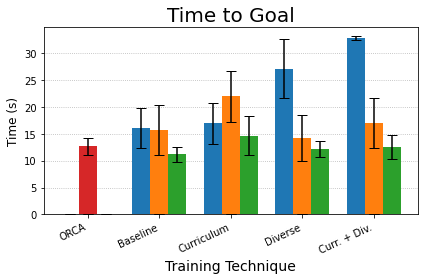

Method order: [(), ('curr',), ('div',), ('curr', 'div')]
Labels: ['ORCA', 'Baseline', 'Curriculum', 'Diverse', 'Curr. + Div.']



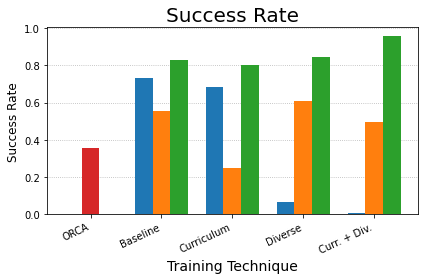

Method order: [(), ('curr',), ('div',), ('curr', 'div')]
Labels: ['ORCA', 'Baseline', 'Curriculum', 'Diverse', 'Curr. + Div.']



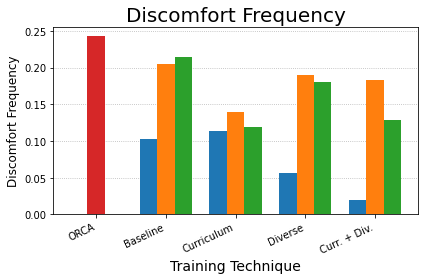

Method order: [(), ('curr',), ('div',), ('curr', 'div')]
Labels: ['ORCA', 'Baseline', 'Curriculum', 'Diverse', 'Curr. + Div.']



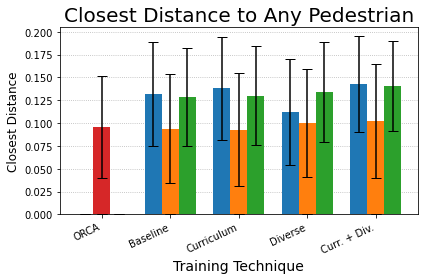

In [81]:
def res_plot(df, metric, std=None, orca=None):
    """
    Produces bar plot of results over all (policy + training method) setups, for a given metric.
    
    Arguments:
    df (pd.DataFrame): df with averaged result values 
    metric (str): metric to be plotted; must be one of the column names 
    std (str): standard deviation of metric; must be one of the column names 
    """
    
    # Labels according to 
    title_dict = {
        'time': 'Time to Goal',
        'succ': 'Success Rate',
        'coll': 'Collision Rate',
        'rew': 'Average Reward',
        'disc_freq': 'Discomfort Frequency',
        'danger_d_min': 'Closest Distance to Any Pedestrian'
        
    }
    
    
    y_dict = {
        'time': 'Time (s)',
        'succ': 'Success Rate',
        'coll': 'Collision Rate',
        'rew': 'Reward',
        'disc_freq': 'Discomfort Frequency',
        'danger_d_min': 'Closest Distance'
        
    }
    assert metric in df.columns
    
    lstm  = df[(df.Policy == 'lstm') ]
    cadrl = df[(df.Policy == 'cadrl')]
    sarl  = df[(df.Policy == 'sarl') ]
    
    # make sure order is the same
    assert lstm['Methods'].tolist() == cadrl['Methods'].tolist() and cadrl['Methods'].tolist() == sarl['Methods'].tolist(), \
        f'Methods are not in same order between lstm, cadrl, and sarl'
    
    labels = ['Baseline', 'Curriculum', 'Diverse', 'Curr. + Div.']
    if orca:
        labels.insert(0, 'ORCA')
    print(f"Method order: {lstm['Methods'].tolist()}")
    print(f"Labels: {labels}\n")
    
    if std:
        assert std in df.columns and std in ['std_time', 'std_rew', 'std_danger'] and metric in ['time', 'rew', 'danger_d_min']
        err_lstm  = lstm[std].tolist()
        err_cadrl = cadrl[std].tolist()
        err_sarl  = sarl[std].tolist()
        if orca:
            err_orca = orca[std]
            err_lstm.insert(0, 0)
            err_cadrl.insert(0, 0)
            err_sarl.insert(0, 0)
        cap = 5
    else:
        err_lstm  = None
        err_cadrl = None
        err_sarl  = None
        err_orca  = None
        cap = None
    
    # Data arrays will have to have an extra '0' element if we have orca or mpc
    data_cadrl = cadrl[metric].tolist()
    data_lstm  = lstm[metric].tolist()
    data_sarl  = sarl[metric].tolist()
    if orca: #TODO: or MPC
        data_cadrl.insert(0, 0)
        data_lstm.insert(0, 0)
        data_sarl.insert(0, 0)
    
#     for data in [data_cadrl, data_lstm, data_sarl, orca[metric]]:
#         print(f"shape: {len(data)}")
#         print(f"type: {type(data)}")

    x = np.arange(len(labels))  # the label locations
    width = 0.25  # the width of the bars; .25 if 3 models, .35 if 2 models
    
    alph = 1
    
    # 3 models
    fig, ax = plt.subplots()
    ax.bar(x - 1*width, data_cadrl, width, label='CADRL',   yerr=err_cadrl, capsize=cap, zorder=3, alpha=alph, error_kw=dict(alpha=alph))
    ax.bar(x + 0*width, data_lstm,  width, label='LSTM_RL', yerr=err_lstm,  capsize=cap, zorder=3, alpha=alph, error_kw=dict(alpha=alph))
    ax.bar(x + 1*width, data_sarl,  width, label='SARL',    yerr=err_sarl,  capsize=cap, zorder=3, error_kw=dict(alpha=alph))
    
    if orca:
        ax.bar(x + 0*width, orca[metric],  width, label='ORCA',    yerr=err_orca,  capsize=cap, zorder=3, alpha=alph, error_kw=dict(alpha=alph))

    # 2 models
#     ax.bar(x - 0.5*width, lstm[metric],  width, label='LSTM_RL', yerr=err_lstm,  capsize=cap)
#     #ax.bar(x + 0*width, cadrl[metric], width, label='CADRL',   yerr=err_cadrl, capsize=cap)
#     ax.bar(x + 0.5*width, sarl[metric],  width, label='SARL',    yerr=err_sarl,  capsize=cap)

    #rects1 = ax.bar(x - width/2, men_means, width, label='SARL', yerr=[1]*5, capsize=8)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    assert metric in y_dict.keys()
    
    ax.set_ylabel(y_dict[metric], fontsize=12)
    ax.set_xlabel("Training Technique", fontsize=14)
    
    ax.yaxis.grid(True, linestyle='dotted', zorder=0)
    
    #ax.set_title(title_dict[metric])
    ax.set_title(title_dict[metric], fontsize=20)
    
    ax.set_xticks(x, labels, rotation=25, ha='right')
    #ax.legend(bbox_to_anchor=(1, 1)) # make legend appear outside of plot
    

    #numbers on top
    # ax.bar_label(rects1, padding=3)
    # ax.bar_label(rects2, padding=3)

    fig.tight_layout()
    
    # make background not transparent
    fig.patch.set_facecolor('white')
    
    plt.savefig(f'figs/{metric}.png', dpi=400, pad_inches=2)
    plt.show()
    
res_plot(avgs_by_training, "time", "std_time", orca=orca_dict)
res_plot(avgs_by_training, "succ", orca=orca_dict)
res_plot(avgs_by_training, "disc_freq", orca=orca_dict)
res_plot(avgs_by_training, "danger_d_min", "std_danger", orca=orca_dict)

In [38]:
# Create lists for the plot

x_pos = np.arange(len(default['time']))

# Build the plot
fig, ax = plt.subplots()

#ax.bar(x_pos, default['time'], yerr=default['std_time'], align='center', capsize=10)
ax.bar(x_pos, default['time'], yerr=default['std_time'], capsize=10, width = 0.25)
# ax.bar(X + 0.00, data[0], width = 0.25)
ax.set_ylabel('Time to goal (s)')
ax.set_xticks(x_pos)
ax.set_xticklabels(default['Policy'])
ax.set_title('Time')
ax.yaxis.grid(True)

# Save the figure and show
#plt.tight_layout()
#plt.savefig('bar_plot_with_error_bars.png')
plt.show()

NameError: name 'default' is not defined

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


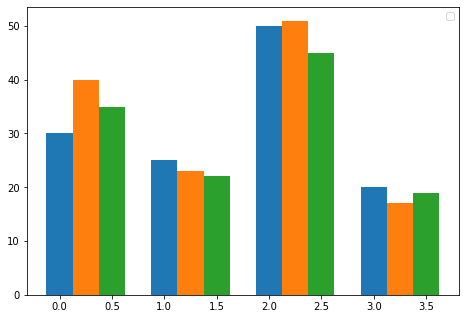

In [59]:
data = [[30, 25, 50, 20],
[40, 23, 51, 17],
[35, 22, 45, 19]]
X = np.arange(4)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['a', 'b', 'c', 'd']


# ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.00, data[0], width = 0.25)
ax.bar(X + 0.25, data[1], width = 0.25)
ax.bar(X + 0.50, data[2], width = 0.25)

ax.set_xticks(X, labels)
ax.legend()
